In [36]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from pept import LineData, Pipeline, PointData
from pept.tracking import Stack, HDBSCAN, Cutpoints, SplitLabels, Centroids, Condition
from scipy.interpolate import interp1d
from skopt import gp_minimize
from skopt.space import Real, Integer
import sys
sys.path.append("/home/rayhaan/randomWalk_V3/Scripts/")
from interpolateTime import interpolateUnique
from tqdm import tqdm
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})
%matplotlib widget

In [37]:
def errorCalculation(truePath: PointData, trackedPath: PointData) -> np.float64:
    fx = interp1d(truePath['t'], truePath['x'], fill_value = "extrapolate")
    fy = interp1d(truePath['t'], truePath['y'], fill_value = "extrapolate")
    fz = interp1d(truePath['t'], truePath['z'], fill_value = "extrapolate")

    xInterp = fx(trackedPath['t'])
    yInterp = fy(trackedPath['t'])
    zInterp = fz(trackedPath['t'])

    errorX = np.sum(np.abs(xInterp - trackedPath['x']))/len(xInterp)
    errorY = np.sum(np.abs(yInterp - trackedPath['y']))/len(xInterp)
    errorZ = np.sum(np.abs(zInterp - trackedPath['z']))/len(xInterp)

    combinedError = np.sqrt(errorX**2 + errorY**2 + errorZ**2)

    return combinedError

In [38]:
def loadTruePath(path: str) -> PointData:
    data = np.loadtxt(path, skiprows = 3)
    points = np.array([data[:, 0], data[:, 5], data[:, 6], data[:, 7]]).T
    pData = PointData(points)
    return pData

def loadData(path: str) -> LineData:
    lines = np.load(path)
    rawLines = np.array([lines[:, 6], lines[:, 0], lines[:, 1], lines[:, 2], lines[:, 3], lines[:, 4], lines[:, 5]]).T
    lData = LineData(rawLines)
    return lData

In [41]:
trueData = loadTruePath(path = "/home/rayhaan/randomWalk_V3/GATE_Generation/Sigma_2.0mm_Varying_Tau_0.08_1.20ms/Placements/RW3_TS_0.08ms_SS_2.00mm.placements")
lors = loadData(path = "/home/rayhaan/randomWalk_V3/GATE_Generation/Sigma_2.0mm_Varying_Tau_0.08_1.20ms/Lines_NPY/RW3_TS_0.08ms_SS_2.00mm.npy")

In [42]:
times = lors['t']
newTime = interpolateUnique(msTime = times)
lors_2 = LineData(np.c_[newTime, lors.lines[:, 1:7]])

In [45]:
MLPipe = Pipeline([
            Stack(sample_size = 35, overlap = 0),
            Cutpoints(max_distance = 3.0),
            HDBSCAN(true_fraction = 0.1),
            SplitLabels() + Centroids(),

            Stack(sample_size = 5, overlap = 4), 
            HDBSCAN(true_fraction = 0.6),
            SplitLabels() + Centroids(),
            Stack()
        ])

In [46]:
locTest = MLPipe.fit(lors_2)
print("The location rate is {} Hz".format(len(locTest.points)/0.5))

Batch 2 / 2 :: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 8730/8730 [00:05<00:00, 1674.05it/s]



Processed samples in 10.914387941360474 s

The location rate is 16530.0 Hz


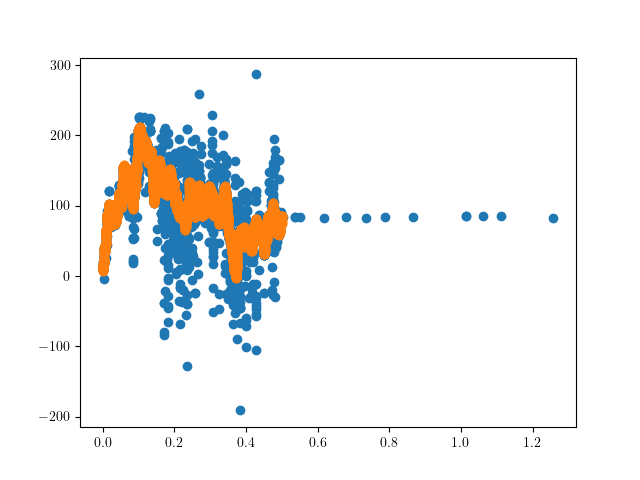

In [47]:
plt.close("all")
fig, ax = plt.subplots(1, 1)
ax.scatter(locTest['t'], locTest['x'])
ax.scatter(trueData['t'], trueData['x'])



In [33]:
# filter2 = Condition("t >= 0.0, t <= 0.5") + Stack()
# locTest2 = filter2.fit(locTest)a

In [59]:
# np.save("/home/rayhaan/randomWalk_V3/Plots/truePath", arr = trueData.points)

In [60]:
# plt.close("all")
# fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize = (7, 5), sharex = "col")

# fig.suptitle("TS_0.4ms_Lambda_2.0mm_L_245.954kHz")
# ax1.scatter(locTest2['t'], locTest2['x'], s = 0.1, color = 'k', zorder = 1, label = "ML_Track")
# ax1.plot(trueData['t'], trueData['x'], lw = 1, color = 'r', zorder = 0, label = "True_Path")

# ax2.scatter(locTest2['t'], locTest2['y'], s = 0.1, color = 'k', zorder = 1, label = "ML_Track")
# ax2.plot(trueData['t'], trueData['y'], lw = 1, color = 'r', zorder = 0, label = "True_Path")

# ax3.scatter(locTest2['t'], locTest2['z'], s = 0.1, color = 'k', zorder = 1, label = "ML_Track")
# ax3.plot(trueData['t'], trueData['z'], lw = 1, color = 'r', zorder = 0, label = "True_Path")

# ax1.legend()
# ax2.legend()
# ax3.legend()

# ax3.set_xlabel("t (s)")

# ax1.set_ylabel("X (mm)")
# ax2.set_ylabel("Y (mm)")
# ax3.set_ylabel("Z (mm)")

# fig.tight_layout()
# fig.savefig("/home/rayhaan/randomWalk_V3/Plots/Test_Extreme_OL1.png", dpi = 300)




In [22]:
def optAllML(lowerLocRate, upperLocRate, Data, truePath):

    # out = []

# for i in tqdm(range(len(UsedSampleSizes)-1)):
    def ObjectiveML(x):
        MLPipe = Pipeline([
            Stack(sample_size = x[0], overlap = 0),
            Cutpoints(max_distance = 3.0),
            HDBSCAN(true_fraction = x[1]),
            SplitLabels() + Centroids(),

            Stack(sample_size = 5, overlap = 4), 
            HDBSCAN(true_fraction = x[2]),
            SplitLabels() + Centroids(),
            Stack()
        ])

        locs = MLPipe.fit(Data, verbose = True)

        locRate = len(locs.points)/0.5

        error = errorCalculation(truePath = truePath, trackedPath = locs)

        if (locRate >= lowerLocRate) and (locRate <= upperLocRate):
            error = error
        else:
            error = 10000 + error

        print("The error is: {} mm, the location rate is: {} kHz".format(error, locRate))

        return error

    space = [   Integer(210, 230, name = 'SS1'),
                # Real(1.0, 3.0, name = 'MD'),
                Real(0.1, 0.6, name = 'TF1'),
                Real(0.55, 0.65, name = 'TF2'),
                    ]

    res = gp_minimize(ObjectiveML, space, n_calls = 20, verbose = True, random_state = 657333)

    out1 = [res.fun, res.x[0], res.x[1], res.x[2]]

    return out1

In [23]:
1/(0.70e-3)

1428.5714285714287

In [26]:
lowerLocRate = 1200
upperLocRate = 1600


In [27]:
optVals = optAllML(lowerLocRate = lowerLocRate, upperLocRate = upperLocRate, Data = lors_2, truePath = trueData)

Iteration No: 1 started. Evaluating function at random point.


Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 754/754 [00:00<00:00, 1404.75it/s]



Processed samples in 12.365432262420654 s

The error is: 39.461013018308954 mm, the location rate is: 1490.0 kHz
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 12.3699
Function value obtained: 39.4610
Current minimum: 39.4610
Iteration No: 2 started. Evaluating function at random point.


Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 656/656 [00:00<00:00, 1220.21it/s]



Processed samples in 25.280187606811523 s

The error is: 40.10794926018498 mm, the location rate is: 1296.0 kHz
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 25.2845
Function value obtained: 40.1079
Current minimum: 39.4610
Iteration No: 3 started. Evaluating function at random point.


Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 732/732 [00:00<00:00, 1249.57it/s]



Processed samples in 5.174568176269531 s

The error is: 10036.717144798697 mm, the location rate is: 146.0 kHz
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 5.1784
Function value obtained: 10036.7171
Current minimum: 39.4610
Iteration No: 4 started. Evaluating function at random point.


Batch 1 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 774/774 [00:00<00:00, 1328.92it/s]


KeyboardInterrupt: 

In [34]:
optVals

[0.4895329639353766, 397, 0.1961781277701768, 0.612509105389874]

In [35]:
MLPipeOpt = Pipeline([
            Stack(sample_size = optVals[1], overlap = 0),
            Cutpoints(max_distance = 3.0),
            HDBSCAN(true_fraction = optVals[2]),
            SplitLabels() + Centroids(),

            Stack(sample_size = 5, overlap = 4), 
            HDBSCAN(true_fraction = optVals[3]),
            SplitLabels() + Centroids(),
            Stack()
        ])

In [36]:
optLocs = MLPipeOpt.fit(lors_2)
print("The location rate is {:.2f} Hz".format(len(optLocs.points)/0.5))

Batch 2 / 2 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 414/414 [00:00<00:00, 6492.51it/s]



Processed samples in 62.286206007003784 s

The location rate is 818.00 Hz


In [37]:
optLocs

pept.PointData (samples: 414)
-----------------------------
sample_size = [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1]
overlap = None
points = 
  (rows: 409, columns: 4)
  [[2.27161166e-03 8.21308661e+00 

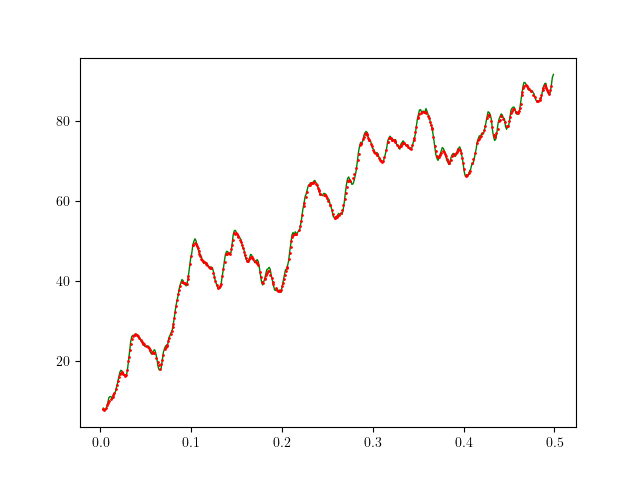

In [38]:
plt.close("all")
fig, ax = plt.subplots(1, 1)

ax.scatter(optLocs['t'], optLocs['x'], color = 'r', s = 1, zorder = 1)
ax.plot(trueData['t'], trueData['x'], color = 'g', lw = 1, zorder = 0)

In [39]:
filter1 = Condition("t >= 0.0, t <= 0.5") + Stack()
filteredLocs = filter1.fit(optLocs)

Batch 1 / 1 :: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 414/414 [00:00<00:00, 6596.72it/s]



Processed samples in 0.43818068504333496 s



In [40]:
np.save("/home/rayhaan/randomWalk_V3/GATE_Generation/Sigma_2.0mm_Tau_0.08ms_1.2ms_tracks/RW3_TS_1.20ms_SS_2.00mm.npy", arr = filteredLocs.points)

In [41]:
uncertainty = errorCalculation(truePath = trueData, trackedPath = optLocs)

In [42]:
print("The uncertainty is {} mm".format(uncertainty))

The uncertainty is 0.5198666944975393 mm


: 